In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
%time
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 4.77 μs


In [3]:
# configuration settings
data_root = '../data/Emory-4DCT'
mask_roi = 'lung_regions'
mesh_radius = 10
num_levels = 3
num_conv_layers = 2
conv_channels = 8
conv_kernel_size = 3
output_func = 'relu'
batch_size = 1
learning_rate = 1e-5

save_every = 10
save_prefix = '2024-10-28__4dct'
#save_prefix = f'2024-09-30__initial/train__batch_size__{mesh_radius}__{interp_radius}__{interp_sigma}__{output_func}__{batch_size}/'
load_epoch = 0

In [4]:
%autoreload
train_images = project.imaging.Emory4DCT(data_root, phases=range(10, 100, 10))
test_images = project.imaging.Emory4DCT(data_root, phases=[0])
train_images

Emory4DCT('../data/Emory-4DCT', 10 cases)

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T10/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T20/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T30/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T40/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T60/

<IPython.core.display.Javascript object>


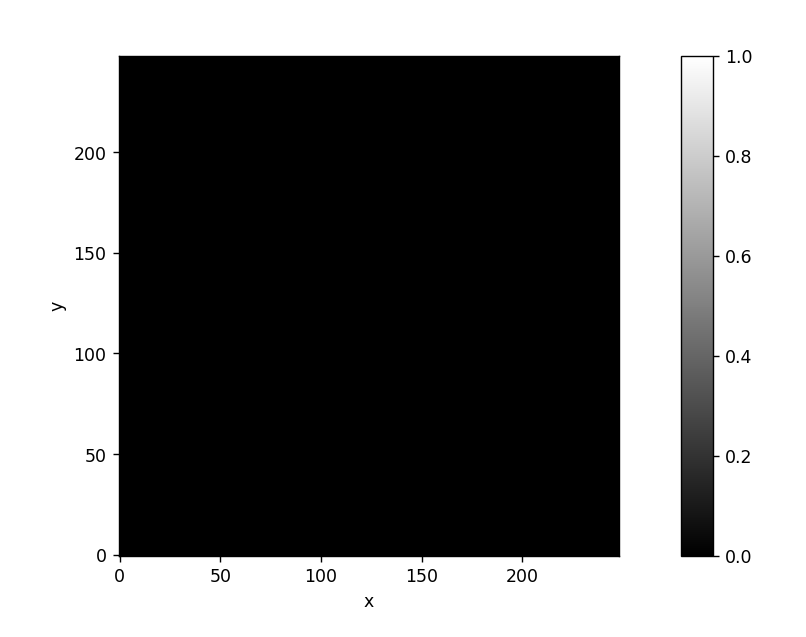

interactive(children=(SelectionSlider(description='phase', options=((10, 0), (20, 1), (30, 2), (40, 3), (50, 4…

CT


<IPython.core.display.Javascript object>


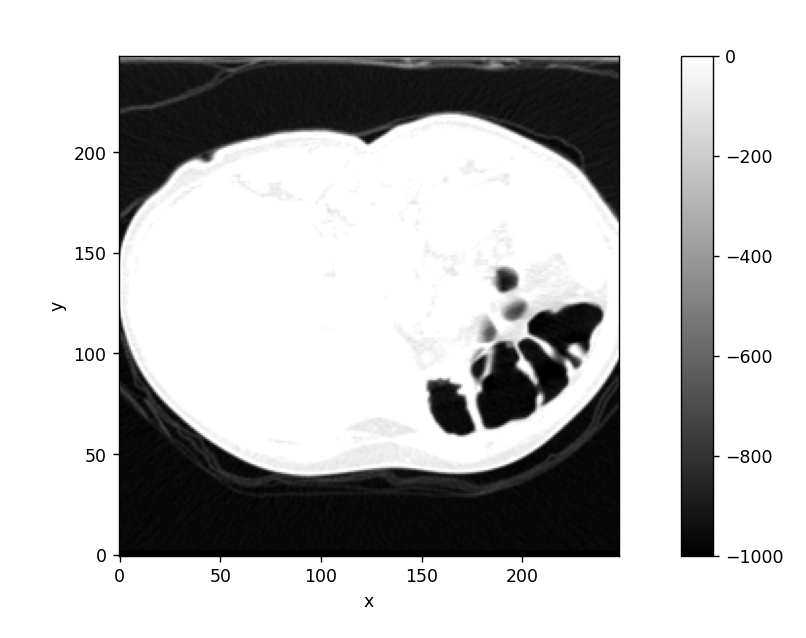

interactive(children=(SelectionSlider(description='phase', options=((10, 0), (20, 1), (30, 2), (40, 3), (50, 4…

CT


<IPython.core.display.Javascript object>


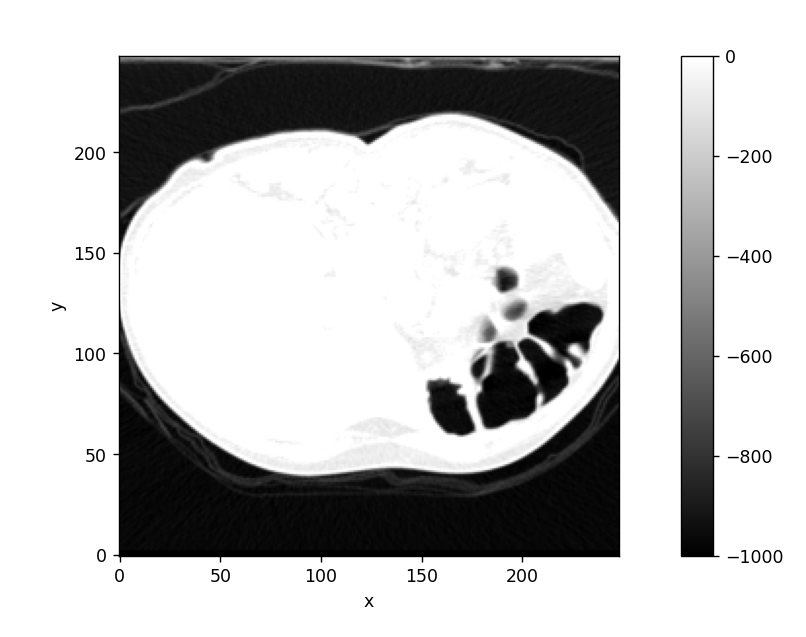

interactive(children=(SelectionSlider(description='phase', options=((10, 0), (20, 1), (30, 2), (40, 3), (50, 4…

displacement


<IPython.core.display.Javascript object>


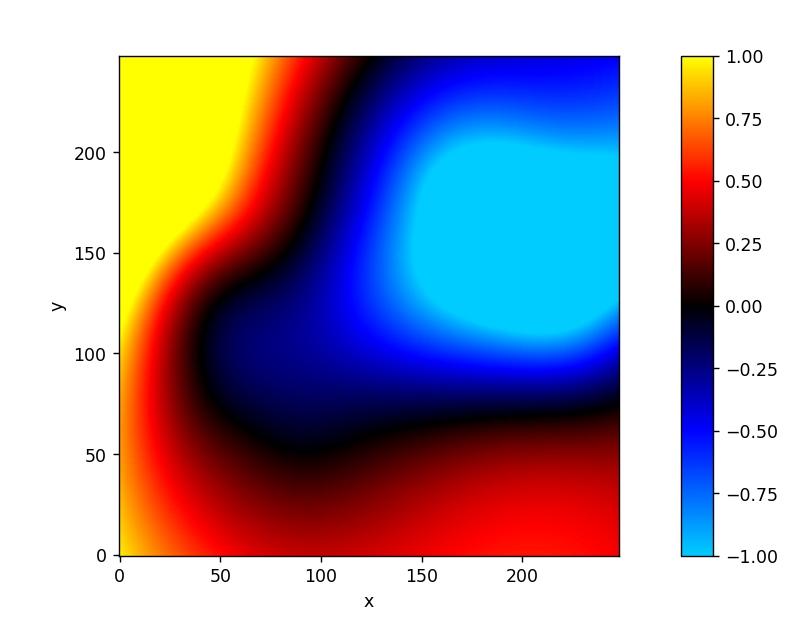

interactive(children=(SelectionSlider(description='fixed_phase', options=((10, 0), (20, 1), (30, 2), (40, 3), …

In [5]:
case = train_images[0]
case.load_niftis()
case.load_masks(roi='lung_regions')
case.load_displacements(moving_phase=10, relative=True)
case.load_meshes(roi='lung_regions', mesh_radius=10)

view = project.visual.XArrayViewer
view(case.mask)
view(case.anat, vmin=-1000, vmax=0)
view(case.anat, vmin=-1000, vmax=0)
view(case.disp)

In [6]:
train_examples = train_images.get_examples(mask_roi, mesh_radius)
test_examples = test_images.get_examples(mask_roi, mesh_radius)
len(train_examples), len(test_examples)

(90, 10)

In [7]:
%autoreload
train_data = project.data.Dataset(train_examples)
test_data = project.data.Dataset(test_examples)

In [8]:
model = project.model.UNet3D(
    in_channels=1,
    out_channels=1,
    num_levels=num_levels,
    num_conv_layers=num_conv_layers,
    conv_channels=conv_channels,
    conv_kernel_size=conv_kernel_size,
).cuda()

In [9]:
%autoreload
trainer = project.training.Trainer(
    model=model,
    train_data=train_data,
    test_data=test_data,
    batch_size=batch_size,
    learning_rate=learning_rate,
    save_every=save_every,
    save_prefix=save_prefix,
    sync_cuda=True
)

In [10]:
if load_epoch:
    trainer.load_state(epoch=load_epoch)

In [11]:
%%time
# test forward pass and initialize viewers
trainer.timer.start()
trainer.run_next_batch(phase='test', epoch=0)

Loading ../data/Emory-4DCT/Case6Pack/NIFTI/case6_T00.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/CorrField/case6_T10_T00.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case6Pack/TotalSegment/case6_T00/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T00_lung_regions_10.xdmf... 45424
['case6_T00.nii'].

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.79 GiB. GPU 0 has a total capacity of 15.56 GiB of which 521.44 MiB is free. Process 46761 has 3.54 GiB memory in use. Including non-PyTorch memory, this process has 11.51 GiB memory in use. Of the allocated memory 9.04 GiB is allocated by PyTorch, and 2.33 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer.save_metrics()
trainer.save_viewers()
trainer.save_state()

In [ ]:
%%time
trainer.timer.start()
trainer.train(num_epochs=100)

In [ ]:
trainer.evaluator.metrics

In [ ]:
trainer.timer.usage

In [ ]:
trainer.timer.usage.groupby(['phase', 'event']).mean().sort_values('time')

In [ ]:
trainer.timer.usage.reset_index()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

t = trainer.timer.usage.reset_index()

fig, ax = plt.subplots()
sns.lineplot(t[t.phase == 'train'], y='mem_used', x='batch')
fig.tight_layout()

In [ ]:


fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage, y='event', x='time', hue='phase', estimator='mean', ax=ax)
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(trainer.timer.usage , y='event', x='time', hue='phase', estimator='sum', ax=ax)
#ax.set_xscale('log')
ax.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(trainer.timer.usage, y='time', x='phase', estimator='sum', ax=ax)
ax.set_ylabel('time (s)')
fig.tight_layout()

In [ ]:
test_data[0][-5].mean()